In [1]:
import numpy as np
import matplotlib.pyplot as plt

import camb
from tqdm import tqdm
from scipy.linalg import cholesky

planck = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1)
ell = planck[:, 0]
spec = planck[:, 1]
errs = 0.5 * (planck[:, 2] + planck[:, 3])

# Part 1

Reduced chi-squared for the suggested set of parameters is $\chi^2_{red} = 1.31 \gtrsim 1$, which gives slightly underfitted, but acceptable result.

In [2]:
def get_spectrum(H0, ombh2, omch2, tau, As, ns, lmax=3000):
    cpars = camb.CAMBparams()
    cpars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0.06, omk=0, tau=tau)
    cpars.InitPower.set_params(As=As, ns=ns, r=0)
    cpars.set_for_lmax(lmax, lens_potential_accuracy=0)
    results = camb.get_results(cpars)
    powers = results.get_cmb_power_spectra(cpars, CMB_unit='muK')
    cmb = powers['total']
    tt = cmb[:,0]
    return tt[2:]

chisq is  15267.937150261656  for  [6.e+01 2.e-02 1.e-01 5.e-02 2.e-09 1.e+00]
chisq is  3272.2053559202204  for  [6.9e+01 2.2e-02 1.2e-01 6.0e-02 2.1e-09 9.5e-01]
Reduced chisq:	1.3052275053530995


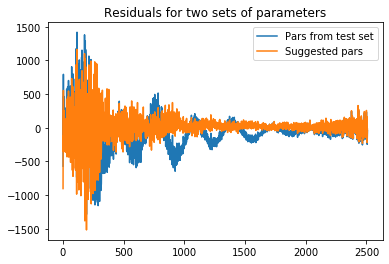

In [3]:
pars = np.asarray([60, 0.02, 0.1, 0.05, 2.0e-9, 1.])
model = get_spectrum(*pars)
model = model[:len(spec)]
resid = spec - model
chisq = np.sum((resid / errs)**2)
print("chisq is ", chisq, " for ", pars)

pars2 = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
model2 = get_spectrum(*pars2)
model2 = model2[:len(spec)]
resid2 = spec - model2
chisq2 = np.sum((resid2 / errs)**2)
print("chisq is ", chisq2, " for ", pars2)

chi_red = chisq2 / len(resid2)
print(f"Reduced chisq:\t{chi_red}")

#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt', skiprows=1)
errs_binned = 0.5 * (planck_binned[:, 2] + planck_binned[:,3]);
plt.clf()
plt.plot(ell, resid, label="Pars from test set")
plt.plot(ell, resid2, label="Suggested pars")
plt.title('Residuals for two sets of parameters')
plt.legend()
plt.savefig("ps4_p1.png", dpi=500)

# Part 2

In [4]:
def ndiff(func, x):
    dx = 0.005 * x
    return (func(x + dx) - func(x - dx)) / (2 * dx)

In [5]:
def fit_newton(pars, y, errs, niter=10):
    m = pars.copy()
    chisq_old = 1
    
    for i in range(niter):
        model = get_spectrum(*m)
        derivs = []
        
        for i in range(len(pars)):
            deriv = ndiff(lambda x: get_spectrum(*m[:i], x, *m[i+1:]), m[i])
            derivs.append(deriv)
        
        derivs = np.vstack(derivs)
        derivs = derivs.T
        model = model[:len(y)]
        derivs = derivs[:len(y), :]
        r = y - model
        chisq = np.sum((r / errs)**2)
        N_1 = np.eye(len(errs)) / errs**2
        lhs = derivs.T @ N_1 @ derivs
        rhs = derivs.T @ N_1 @ r
        curv = np.linalg.inv(lhs)
        dm = curv @ rhs
        newm = m.copy()
        newm += dm

        print("==================================")
        print('Chisq = ', chisq)
        print('dm = ', dm)
        print('m after iteration:', newm)
        m = newm
        merr = np.sqrt(np.diag(curv))
        print("Errors = ", merr)
        if np.abs(chisq - chisq_old) / chisq_old < 0.01:
            print('Break | delta chisq = ', np.abs(chisq - chisq_old) / chisq_old * 100, "%")
            break
        chisq_old = chisq
    return m, merr, curv

In [6]:
pars0 = np.asarray([69., 0.022, 0.12, 0.02, 2.1e-9, 0.95])

m, merr, curv = fit_newton(pars0, spec, errs)
print("Result:")
print(m)
print(merr)

Chisq =  4379.651632425396
dm =  [-4.42679421e-01  3.86532033e-04 -2.73607478e-03  9.88711791e-02
  2.59896452e-10  2.24138190e-02]
m after iteration: [6.85573206e+01 2.23865320e-02 1.17263925e-01 1.18871179e-01
 2.35989645e-09 9.72413819e-01]
Errors =  [1.08947847e+00 2.13169813e-04 2.45144103e-03 3.52988901e-02
 1.42441392e-10 5.67163788e-03]
Chisq =  2596.510702614868
dm =  [-5.08456673e-01 -4.31711998e-05  8.39626525e-04 -4.04573380e-02
 -1.74988551e-10 -5.98495697e-04]
m after iteration: [6.80488639e+01 2.23433608e-02 1.18103552e-01 7.84138411e-02
 2.18490790e-09 9.71815323e-01]
Errors =  [1.19424131e+00 2.28294426e-04 2.66390375e-03 3.11686228e-02
 1.37775571e-10 6.78359306e-03]
Chisq =  2580.493428255015
dm =  [ 2.26808022e-01  2.47364470e-05 -5.11427193e-04  8.63209622e-03
  4.07847592e-11  1.40684048e-03]
m after iteration: [6.82756719e+01 2.23680973e-02 1.17592125e-01 8.70459373e-02
 2.22569266e-09 9.73222164e-01]
Errors =  [1.19031058e+00 2.29768411e-04 2.67353286e-03 3.4803

In [7]:
fit_res = np.vstack([m, merr])
np.savetxt("planck_t_params.txt", fit_res.T, header="Value\tError")

# Part 3

For this problem I have run MCMC of 11500 steps in total (24h of actual calculation). I run it on the claster, so here I provide an example code, but then load an actual chain from the file.

I multiplied a matrix from Cholesky decomposition by a factor of $0.85$ to make steps a bit smaller, because previous chains had acceptance rate $\sim 10$%. And this modification improved it to the $\sim 26$%.

An ideal sampler draws from the underlying distribution with no correlations between successive elements of the chain. This represents a white noise spectrum. An actual MCMC chain has correlations on small scales due to the nature of the algorithm. So if we examine the power spectrum of an actual (converged) chain, there will be a white noise on the large scales (small $k$). Power spectrum of my chains fulfill this condition, so I consider them converged.

In [60]:
niter = 100
# ==================
L = cholesky(curv, lower=False) * 0.85
mc = m.copy()
m_history = np.array([])
chisq_old = 2580.493007619295
chisq_history = np.array([])
print("Chisq start: ", chisq_old)

acc = 0
rej = 1

pbar = tqdm(range(niter), desc=f"{chisq_old:.2f}")
for i in pbar:
    dm = np.random.normal(size=6) @ L
    model = get_spectrum(*(mc + dm))
    model = model[:len(spec)]
    r = spec - model
    chisq = np.sum((r / errs)**2)
    if chisq - chisq_old < 0:
        mc = mc + dm
        m_history = np.append(m_history, mc)
        chisq_history = np.append(chisq_history, chisq)
        chisq_old = chisq
        acc += 1
        pbar.set_description(f"Cur. chi2 {chisq:.2f} | Acceptance: {acc / (i+1) * 100:.1f}%")
    else:
        rn = np.random.rand()
        if rn < np.exp(0.5 * (chisq_old - chisq)):
            mc = mc + dm
            m_history = np.append(m_history, m)
            chisq_history = np.append(chisq_history, chisq)
            chisq_old = chisq
            acc += 1
            pbar.set_description(f"Cur. chi2 {chisq:.2f} | Acceptance: {acc / (i+1) * 100:.1f}%")
            continue
        m_history = np.append(m_history, m)
        chisq_history = np.append(chisq_history, chisq_old)
        rej += 1
        pbar.set_description(f"Cur. chi2 {chisq_old:.2f} | Acceptance: {acc / (i+1) * 100:.1f}%")

Chisq start:  2580.493007619295


Cur. chi2 2580.82 | Acceptance: 32.0%: 100%|█████████████████████████████████████████| 100/100 [06:39<00:00,  4.17s/it]


In [20]:
m_hist = np.reshape(m_history, (-1, 6)).T
hist = np.vstack([m_hist, chisq_history])
# np.savetxt("planck_chain.txt", hist.T, header="H0\tombh2\tomch2\ttau\tAs\tns\tchisq")

In [8]:
# Loading chains from file
chain_data = np.loadtxt("planck_chain.txt")
h0_chain = chain_data[:, 0]
ombh2_chain = chain_data[:, 1]
omch2_chain = chain_data[:, 2]
tau_chain = chain_data[:, 3]
As_chain = chain_data[:, 4]
ns_chain = chain_data[:, 5]
chisq_chain = chain_data[:, 6]

chi_old = -1
acc = -1
for i in range(len(chisq_chain)):
    if chisq_chain[i] != chi_old:
        acc += 1
        chi_old = chisq_chain[i]
        
print(f"Acceptance rate: {acc / len(chisq_chain) * 100:.1f}%")

Acceptance rate: 25.8%


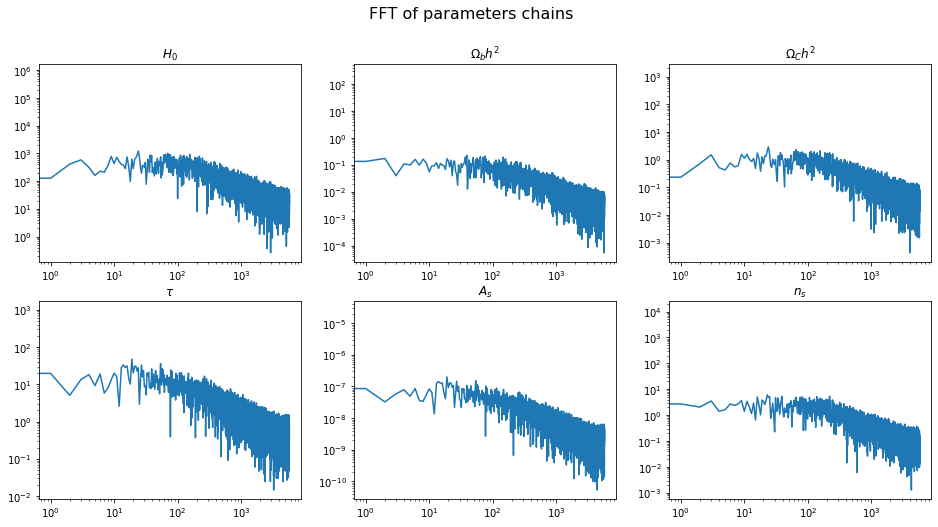

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle("FFT of parameters chains", fontsize=16)

axs[0, 0].loglog(np.abs(np.fft.rfft(h0_chain)))
axs[0, 0].set_title(r'$H_0$')

axs[0, 1].loglog(np.abs(np.fft.rfft(ombh2_chain)))
axs[0, 1].set_title(r'$\Omega_b h^2$')

axs[0, 2].loglog(np.abs(np.fft.rfft(omch2_chain)))
axs[0, 2].set_title(r'$\Omega_C h^2$')

axs[1, 0].loglog(np.abs(np.fft.rfft(tau_chain)))
axs[1, 0].set_title(r'$\tau$')

axs[1, 1].loglog(np.abs(np.fft.rfft(As_chain)))
axs[1, 1].set_title(r'$A_s$')

axs[1, 2].loglog(np.abs(np.fft.rfft(ns_chain)))
axs[1, 2].set_title(r'$n_s$')

plt.savefig('ps4_p3.png', dpi=500)

In [10]:
print("=== Parameters estimation ===")

H0 = np.average(h0_chain[1000:])
H0_err = np.std(h0_chain[1000:])
print(f"H0:\t{H0:.2e} +- {H0_err:.2e}")

ombh2 = np.average(ombh2_chain[1000:])
ombh2_err = np.std(ombh2_chain[1000:])
print(f"ombh2:\t{ombh2:.2e} +- {ombh2_err:.2e}")

omch2 = np.average(omch2_chain[1000:])
omch2_err = np.std(omch2_chain[1000:])
print(f"omch2:\t{omch2:.2e} +- {omch2_err:.2e}")

tau = np.average(tau_chain[1000:])
tau_err = np.std(tau_chain[1000:])
print(f"tau:\t{tau:.2e} +- {tau_err:.2e}")

As = np.average(As_chain[1000:])
As_err = np.std(As_chain[1000:])
print(f"As:\t{As:.2e} +- {As_err:.2e}")

ns = np.average(ns_chain[1000:])
ns_err = np.std(ns_chain[1000:])
print(f"ns:\t{ns:.2e} +- {ns_err:.2e}")

=== Parameters estimation ===
H0:	6.83e+01 +- 1.08e+00
ombh2:	2.24e-02 +- 2.15e-04
omch2:	1.17e-01 +- 2.43e-03
tau:	8.41e-02 +- 2.91e-02
As:	2.22e-09 +- 1.22e-10
ns:	9.73e-01 +- 6.06e-03


### Omega_L estimation

\begin{equation}
\Omega_\Lambda = 1 - \Omega_b - \Omega_c
\end{equation}

\begin{equation}
\Delta \Omega_\Lambda = \sqrt{\left(\frac{\partial \Omega_\Lambda}{\partial \Omega_b}\right)^2 \Delta \Omega_b^2  + \left(\frac{\partial \Omega_\Lambda}{\partial \Omega_b}\right)^2 \Delta \Omega_b^2} = \sqrt{ \Delta \Omega_b^2  + \Delta \Omega_b^2}
\end{equation}

From MCMC fit we obtain $b = \Omega_b h^2$ and $c = \Omega_c h^2$.

\begin{equation}
\Omega_b = \frac{b}{h^2}
\end{equation}

\begin{equation}
\Delta \Omega_b = \sqrt{\left(\frac{\partial \Omega_b}{\partial b}\right)^2 \Delta b^2  + \left(\frac{\partial \Omega_b}{\partial h}\right)^2 \Delta h^2} = \sqrt{ \left(\frac{1}{h^2}\right)^2 \Delta b^2  + \left(\frac{2b}{h^3}\right)^2 \Delta h^2}
\end{equation}

\begin{equation}
\Omega_c = \frac{c}{h^2}
\end{equation}

\begin{equation}
\Delta \Omega_c = \sqrt{\left(\frac{\partial \Omega_c}{\partial c}\right)^2 \Delta c^2  + \left(\frac{\partial \Omega_c}{\partial h}\right)^2 \Delta h^2} = \sqrt{ \left(\frac{1}{h^2}\right)^2 \Delta c^2  + \left(\frac{2c}{h^3}\right)^2 \Delta h^2}
\end{equation}

We also have $h = \frac{H_0}{100}$, so:

\begin{equation}
\Delta h = \sqrt{\left(\frac{\partial h}{\partial H_0}\right)^2 \Delta H_0^2} = \sqrt{ \left(\frac{\Delta H_0}{100}\right)^2 }
\end{equation}

In [11]:
h = H0 / 100
h_err = H0_err / 100
print(f"h:\t{h:.4f} +- {h_err:.4f}")

Omega_b = ombh2 / h**2
Omega_b_err = np.sqrt(ombh2_err**2 / h**4 + h_err**2 * 4 * ombh2**2 / h**6)
print(f"Om_b:\t{Omega_b:.4f} +- {Omega_b_err:.4f}")

Omega_c = omch2 / h**2
Omega_c_err = np.sqrt(omch2_err**2 / h**4 + h_err**2 * 4 * omch2**2 / h**6)
print(f"Om_b:\t{Omega_c:.4f} +- {Omega_c_err:.4f}")

Omega_L = 1 - Omega_b - Omega_c
Omega_L_err = np.sqrt(Omega_b_err**2 + Omega_c_err**2)
print(f"Om_L:\t{Omega_L:.4f} +- {Omega_L_err:.4f}")

h:	0.6833 +- 0.0108
Om_b:	0.0479 +- 0.0016
Om_b:	0.2516 +- 0.0095
Om_L:	0.7004 +- 0.0096


# Part 4

### Importance sampling
To calculate the wighted average we have to calculate the wights first:

\begin{equation}
    p_i = \exp \left( -0.5 \left(\frac{\tau_i - \tau_{prior}}{\sigma_{\tau_{prior}}}\right)^2 \right)
\end{equation}

Second, we must must take into account condition $\sum_i p_i = 1$.

Finally, weighted parameters are calculated as $x = \sum_i x_i p_i$

In [29]:
def mean_std_weighted(values, weights):
    """
    Return the weighted standard deviation.
    """
    aver = values @ weights
    std = np.sqrt((values - aver)**2 @ weights)
    return aver, std


tau_pr = 0.0540
tau_pr_err = 0.0074
p_tau = np.array([np.exp(-0.5 * ((ti - tau_pr) / tau_pr_err)**2) for ti in tau_chain])
p_tau = p_tau / np.sum(p_tau)

H0_new, H0_err_new = mean_std_weighted(h0_chain, p_tau)
ombh2_new, ombh2_err_new = mean_std_weighted(ombh2_chain, p_tau)
ombh2_new, omch2_err_new = mean_std_weighted(omch2_chain, p_tau)
tau_new, tau_err_new = mean_std_weighted(tau_chain, p_tau)
As_new, As_err_new = mean_std_weighted(As_chain, p_tau)
ns_new, ns_err_new = mean_std_weighted(ns_chain, p_tau)

print("=== Previous parameters ===")

print(f"H0:\t{H0:.2e} +- {H0_err:.2e}")
print(f"ombh2:\t{ombh2:.2e} +- {ombh2_err:.2e}")
print(f"omch2:\t{omch2:.2e} +- {omch2_err:.2e}")
print(f"tau:\t{tau:.2e} +- {tau_err:.2e}")
print(f"As:\t{As:.2e} +- {As_err:.2e}")
print(f"ns:\t{ns:.2e} +- {ns_err:.2e}")

print("\n\n=== Parameters estimation with prior tau ===")

print(f"H0:\t{H0_new:.2e} +- {H0_err_new:.2e}")
print(f"ombh2:\t{ombh2_new:.2e} +- {ombh2_err_new:.2e}")
print(f"omch2:\t{omch2_new:.2e} +- {omch2_err_new:.2e}")
print(f"tau:\t{tau_new:.2e} +- {tau_err_new:.2e}")
print(f"As:\t{As_new:.2e} +- {As_err_new:.2e}")
print(f"ns:\t{ns_new:.2e} +- {ns_err_new:.2e}")

=== Previous parameters ===
H0:	6.83e+01 +- 1.08e+00
ombh2:	2.24e-02 +- 2.15e-04
omch2:	1.17e-01 +- 2.43e-03
tau:	8.41e-02 +- 2.91e-02
As:	2.22e-09 +- 1.22e-10
ns:	9.73e-01 +- 6.06e-03


=== Parameters estimation with prior tau ===
H0:	6.78e+01 +- 9.86e-01
ombh2:	1.19e-01 +- 2.25e-04
omch2:	1.19e-01 +- 2.30e-03
tau:	5.58e-02 +- 7.02e-03
As:	2.10e-09 +- 3.04e-11
ns:	9.71e-01 +- 5.63e-03


### New chain with tau_prior

Unfortunately, I failed to run complete mcmc with prior information, because first two attempts was bugged and there is no time for the third, so here I just present general algorithm and code.

In [13]:
def chi2(y, model, noise=None):
    if noise is None:
        return np.sum((y - model)**2)
    else:
        return np.sum (((y - model) / noise)**2)

def prior_chisq(pars, par_priors, par_errs):
    if par_priors is None:
        return 0
    par_shifts = pars - par_errs
    return np.sum((par_shifts / par_errs)**2)

In [14]:
niter = 100
mc = np.array([6.82756719e+01, 2.23680973e-02, 1.17592125e-01, 0.0540, 2.22569266e-09, 9.73222164e-01])
# ==================
L = cholesky(curv, lower=False) * 0.85

m_history = np.array([])
model = get_spectrum(*mc)
model = model[:len(spec)]
chisq_old = chi2(spec, model, errs)
chisq_history = np.array([])
print("Chisq start: ", chisq_old)

par_pr=0 * mc
par_pr[3] = tau_pr
par_pr_errs = 0 * mc + 1e20
par_pr_errs[3] = tau_pr_err

acc = 0
rej = 1

pbar = tqdm(range(niter), desc=f"{chisq_old:.2f}")
for i in pbar:
    dm = np.random.normal(size=6) @ L
    model = get_spectrum(*(mc + dm))
    model = model[:len(spec)]
    chisq = chi2(spec, model, errs) + prior_chisq(mc + dm, par_pr, par_pr_errs)
    
    if chisq - chisq_old < 0:
        mc = mc + dm
        m_history = np.append(m_history, mc)
        chisq_history = np.append(chisq_history, chisq)
        chisq_old = chisq
        acc += 1
        pbar.set_description(f"Cur. chi2 {chisq:.2f} | Acceptance: {acc / (i+1) * 100:.1f}%")
    
    else:
        rn = np.random.rand()
        if rn < np.exp(0.5 * (chisq_old - chisq)):
            mc = mc + dm
            m_history = np.append(m_history, m)
            chisq_history = np.append(chisq_history, chisq)
            chisq_old = chisq
            acc += 1
            pbar.set_description(f"Cur. chi2 {chisq:.2f} | Acceptance: {acc / (i+1) * 100:.1f}%")
            continue
        m_history = np.append(m_history, m)
        chisq_history = np.append(chisq_history, chisq_old)
        rej += 1
        pbar.set_description(f"Cur. chi2 {chisq_old:.2f} | Acceptance: {acc / (i+1) * 100:.1f}%")

Chisq start:  5090.73220244669


Cur. chi2 2623.18 | Acceptance: 7.0%: 100%|██████████████████████████████████████████| 100/100 [05:20<00:00,  3.49s/it]


In [31]:
m_hist = np.reshape(m_history, (-1, 6)).T
hist = np.vstack([m_hist, chisq_history])
np.savetxt("planck_chain_tauprior.txt", hist.T, header="H0\tombh2\tomch2\ttau\tAs\tns\tchisq")

In [30]:
# For a chain with length 100
tau_prior_from_chain = np.average(m_history[3])
tau_prior_from_chain_err = np.std(m_history[3])
print(f"Resampled tau: {tau_new:.3f} +- {tau_err_new:.3f}")
print(f"tau from chain: {tau_prior_from_chain:.3f} +- {tau_prior_from_chain_err:.3f}")

Resampled tau: 0.056 +- 0.007
tau from chain: 0.055 +- 0.000
